In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks, hilbert
from scipy.integrate import odeint

# === Load EEG data (replace with your path) ===
file_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/EEG.csv"
EEG = pd.read_csv(file_path)

real_data_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/Epileptogenic_Results.csv"
df = pd.read_csv(real_data_path)


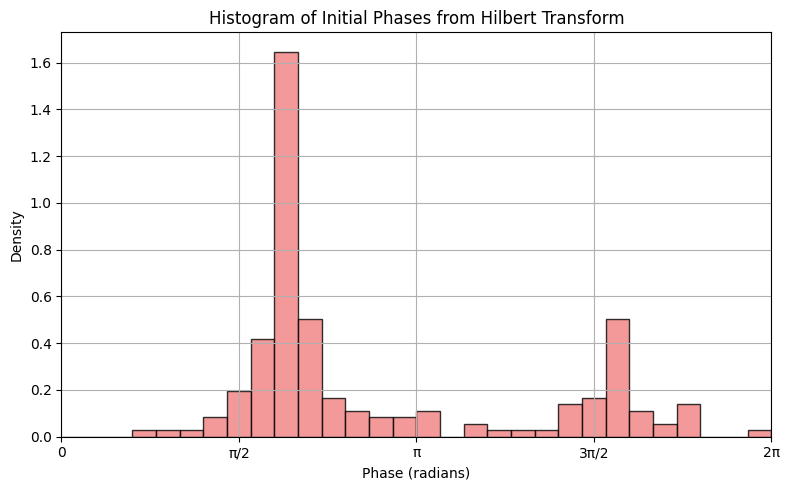

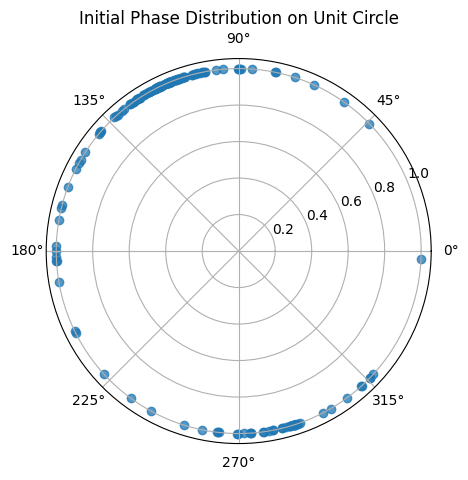

In [8]:
# Initial Phase Distribution
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# === Parameters ===
N = len(EEG.columns)                 # number of EEG channels

# === Get initial phases from Hilbert transform ===
initial_phases = []
for channel in EEG.columns:
    signal = EEG[channel].values
    analytic_signal = hilbert(signal)
    phase = np.angle(analytic_signal)
    initial_phases.append(phase[0])  # phase at time t = 0

x = np.array(initial_phases)  # fixed phases

# Wrap phase values to the range [0, 2π)
x = np.mod(x, 2 * np.pi)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(x, bins=30, density=True, color='lightcoral', edgecolor='black', alpha=0.8, range=(0, 2*np.pi))
plt.title("Histogram of Initial Phases from Hilbert Transform")
plt.xlabel("Phase (radians)")
plt.ylabel("Density")
plt.xlim([0, 2*np.pi])
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', 'π/2', 'π', '3π/2', '2π'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Polar plot of final wrapped phases ===
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)
ax.scatter(x, np.ones_like(x), alpha=0.75)
ax.set_title(f'Initial Phase Distribution on Unit Circle')
plt.show()

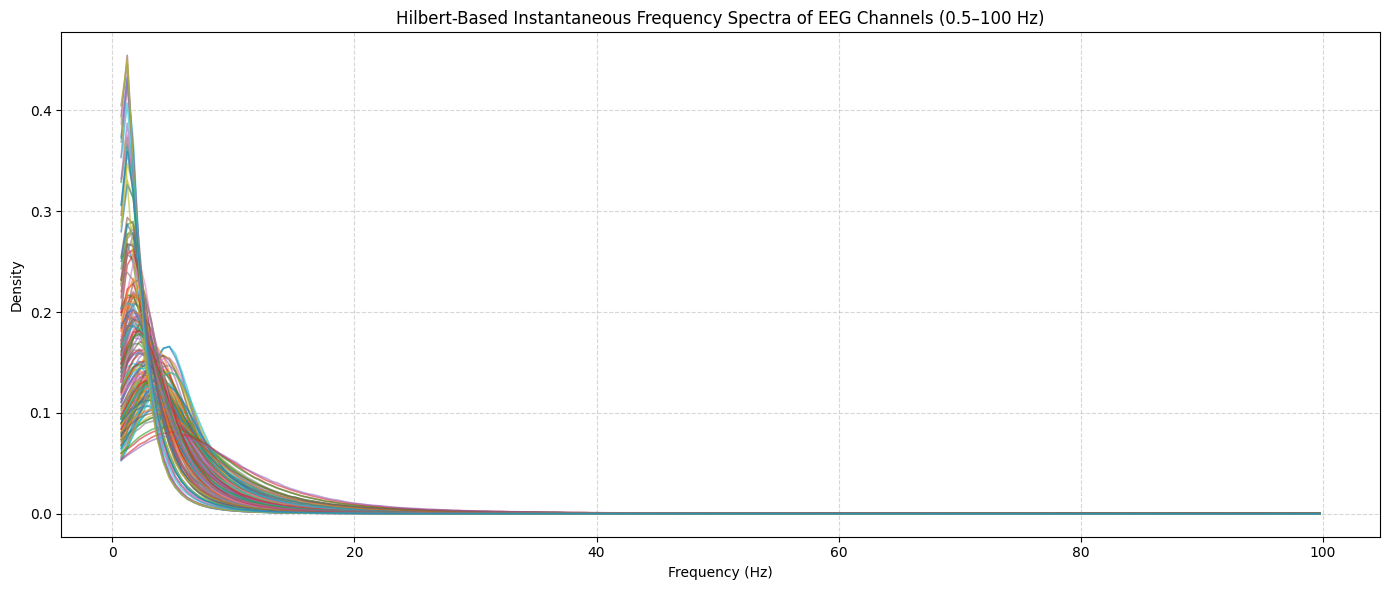

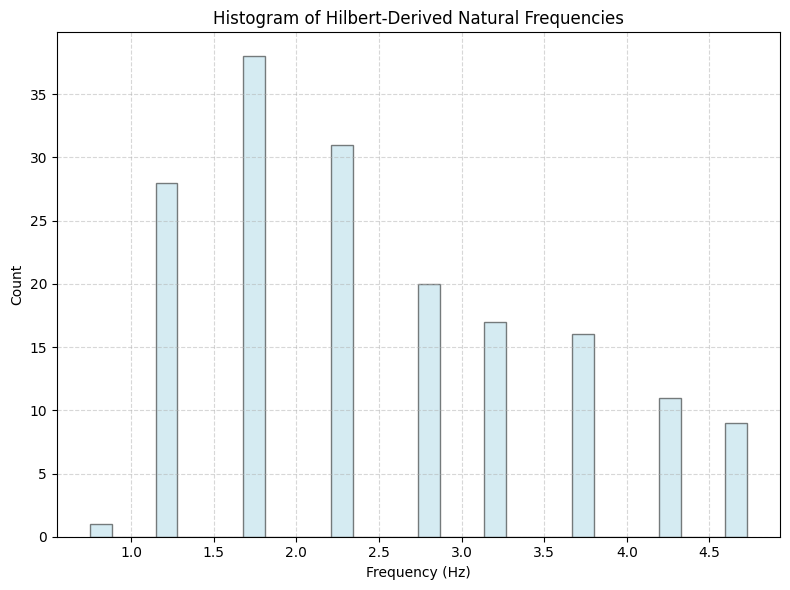

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, find_peaks
from scipy.stats import gaussian_kde

# === Hilbert-based instantaneous frequency function ===
def full_instantaneous_frequency(signal, fs):
    analytic = hilbert(signal)
    phase = np.unwrap(np.angle(analytic))
    inst_freq = np.diff(phase) * fs / (2 * np.pi)
    return inst_freq[np.isfinite(inst_freq)]  # remove NaNs/Infs

# === Parameters ===
fs = 500  # Sampling frequency (Hz)
bins = 200  # Number of histogram bins
freq_range = (0.5, 100)  # Focus on EEG band 

natural_frequencies = []

# === Plot: Overlaid instantaneous frequency spectra ===
plt.figure(figsize=(14, 6))

for ch in EEG.columns:
    signal = EEG[ch].values
    inst_freq = full_instantaneous_frequency(signal, fs)

    # Histogram for spectrum
    hist_vals, bin_edges = np.histogram(inst_freq, bins=bins, range=freq_range, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, hist_vals, alpha=0.6, lw=1.2, label=ch)

    # Find dominant natural frequency
    peak_idx, _ = find_peaks(hist_vals, height=0.01 * np.max(hist_vals))  # adjustable threshold
    if len(peak_idx) > 0:
        dominant_peak_idx = peak_idx[np.argmax(hist_vals[peak_idx])]
        natural_frequency = bin_centers[dominant_peak_idx]
    else:
        natural_frequency = bin_centers[np.argmax(hist_vals)]
    
    natural_frequencies.append(natural_frequency)

plt.title("Hilbert-Based Instantaneous Frequency Spectra of EEG Channels (0.5–100 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.5)
# plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

# === Plot Histogram of Natural Frequencies ===
plt.figure(figsize=(8, 6))
plt.hist(natural_frequencies, bins=30, edgecolor='black', alpha=0.5, color='lightblue')
plt.title("Histogram of Hilbert-Derived Natural Frequencies")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Estimated g(omega): 0.3935
Critical coupling ε_c ≈ 1.6177


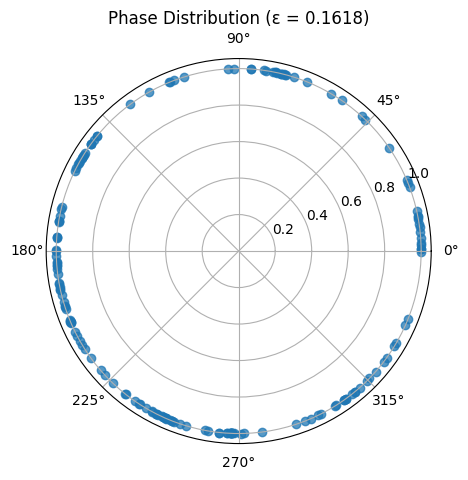

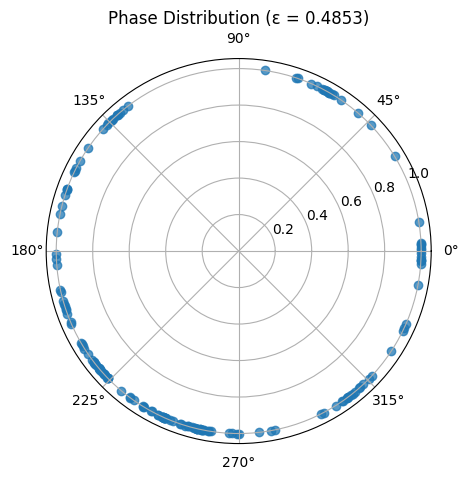

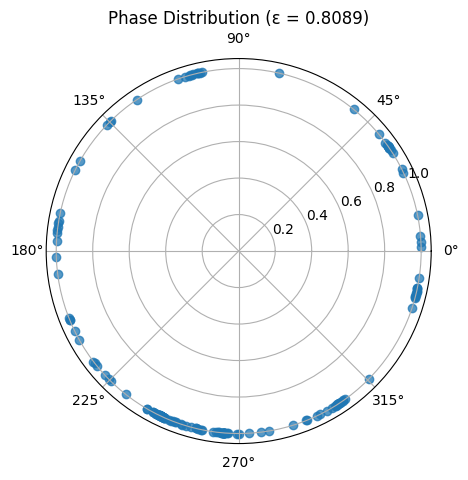

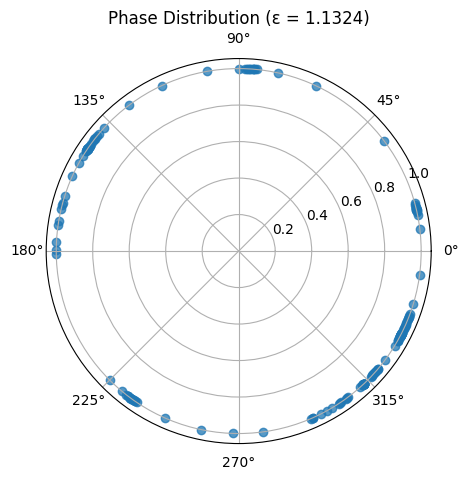

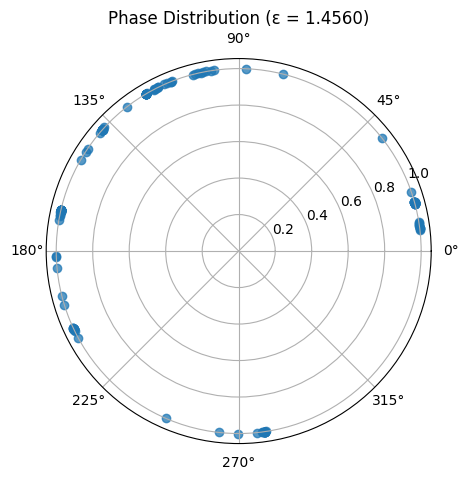

In [10]:
# Kuramoto model simulation with Hilbert-derived natural frequencies with critical epsilon
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, find_peaks
from scipy.stats import gaussian_kde

# === Hilbert-based instantaneous frequency function ===
def full_instantaneous_frequency(signal, fs):
    analytic = hilbert(signal)
    phase = np.unwrap(np.angle(analytic))
    inst_freq = np.diff(phase) * fs / (2 * np.pi)
    return inst_freq[np.isfinite(inst_freq)]  # remove NaNs/Infs

# === Parameters ===
fs = 500  # Sampling frequency (Hz)
bins = 200  # Number of histogram bins
freq_range = (0.5, 100)  # Focus on EEG band 
T_sim = 1500  # Number of time steps for simulation
dt = 0.01  # Time step size
N = len(EEG.columns)  # Number of EEG channels

# === Find peaks and natural frequencies ===
natural_frequencies = []
for ch in EEG.columns:
    signal = EEG[ch].values
    inst_freq = full_instantaneous_frequency(signal, fs)
    hist_vals, bin_edges = np.histogram(inst_freq, bins=bins, range=freq_range, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Find peaks
    peak_idx, _ = find_peaks(hist_vals, height=0.01 * np.max(hist_vals))  # adjust height threshold as needed
    if len(peak_idx) > 0:
        dominant_peak_idx = peak_idx[np.argmax(hist_vals[peak_idx])]
        natural_frequency = bin_centers[dominant_peak_idx]
    else:
        natural_frequency = bin_centers[np.argmax(hist_vals)]  # use global max if no peaks found
    
    natural_frequencies.append(natural_frequency)

omega = natural_frequencies  # frequency vector

# === Step 2: Estimate g(omega) and critical epsilon ===
kde = gaussian_kde(omega)
density_values = kde.evaluate(omega)
g_omega = np.max(density_values)
epsilon_critical = 2 / (np.pi * g_omega)

print(f"Estimated g(omega): {g_omega:.4f}")
print(f"Critical coupling ε_c ≈ {epsilon_critical:.4f}")

# === Step 3: Simulate Kuramoto model ===
epsilons = np.linspace(0.1 * epsilon_critical, 0.9 * epsilon_critical, 5)

initial_phases = []
for channel in EEG.columns:
    signal = EEG[channel].values
    analytic_signal = hilbert(signal)
    phase = np.angle(analytic_signal)
    wrapped_phase = np.mod(phase[0], 2 * np.pi)  # Remap to [0, 2π]
    initial_phases.append(wrapped_phase)

initial_phases = np.array(initial_phases)

# === Simulation ===
for epsilon in epsilons:
    x = np.copy(initial_phases)
    phase_history = np.zeros((T_sim, N))
    phase_history[0] = x

    for t in range(1, T_sim):
        x_new = np.copy(x)
        for k in range(N):
            coupling_sum = np.sum(np.sin(x - x[k]))
            x_new[k] += dt * (omega[k] + (epsilon / N) * coupling_sum)
        x = x_new
        phase_history[t] = x

    time = np.arange(T_sim) * dt

    # === Plot 2: Final phase distribution in polar plot ===
    final_phases = phase_history[-1]
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(111, polar=True)
    ax.scatter(final_phases % (2*np.pi), np.ones_like(final_phases), alpha=0.75)
    ax.set_title(f'Phase Distribution (ε = {epsilon:.4f})')
    plt.show()

In [11]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.utils import resample

# Assuming `omega` is your array of natural frequencies
n_bootstraps = 1000
g_omega_values = []

# Bootstrap resampling
for _ in range(n_bootstraps):
    omega_sample = resample(omega)
    kde = gaussian_kde(omega_sample)
    density_values = kde.evaluate(omega_sample)
    g_omega_values.append(np.max(density_values))

g_omega_values = np.array(g_omega_values)
g_omega_mean = np.mean(g_omega_values)
g_omega_std = np.std(g_omega_values)

epsilon_critical_values = 2 / (np.pi * g_omega_values)
epsilon_critical_mean = np.mean(epsilon_critical_values)
epsilon_critical_std = np.std(epsilon_critical_values)

print(f"Estimated g(omega): {g_omega_mean:.4f} ± {g_omega_std:.4f}")
print(f"Critical coupling ε_c ≈ {epsilon_critical_mean:.4f} ± {epsilon_critical_std:.4f}")


Estimated g(omega): 0.3967 ± 0.0312
Critical coupling ε_c ≈ 1.6146 ± 0.1273


In [12]:
# Epileptogenic comparison from real EEG data - Hilbert Transform
import numpy as np
import pandas as pd
from scipy.signal import hilbert

# === Parameters ===
epsilon = 0.5 * epsilon_critical  # Coupling strength
fs = 500       # Sampling rate (if needed for signal preprocessing)

# === Extract EEG info ===
channels = EEG.columns
N = len(channels)

# === Step 1: Get initial phases using Hilbert Transform ===
initial_phases = []
for channel in EEG.columns:
    signal = EEG[channel].values
    analytic_signal = hilbert(signal)
    phase = np.angle(analytic_signal)
    wrapped_phase = np.mod(phase[0], 2 * np.pi)  # Remap to [0, 2π]
    initial_phases.append(wrapped_phase)

initial_phases = np.array(initial_phases)

x = np.array(initial_phases)  # Initial phases (fixed during TLE calculation)

# === Step 2: Compute TLEs for each channel ===
TLEs = np.zeros(N)
for k in range(N):
    cos_sum = 0
    for j in range(N):
        if j != k:
            cos_sum += np.cos(x[j] - x[k])
    TLEs[k] = - (epsilon / N) * cos_sum

# === Step 3: Threshold TLEs to determine simulated epileptogenicity ===
# Stable (TLE ≤ 0): 1 = Epileptogenic
# Unstable (TLE > 0): 0 = Non-epileptogenic
Epileptogenic_simulated = (TLEs <= 0).astype(int)
Epileptogenic_sim = np.column_stack((channels, Epileptogenic_simulated.astype(str)))

# === Step 4: Load real labels from CSV ===
file_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/Epileptogenic_Results.csv"
df = pd.read_csv(file_path)

# Ensure columns match EEG channels
Epileptogenic_real = np.column_stack((channels, df['Epileptogenic'].astype(str)))

# === Step 5: Cross-tabulation of simulation vs real labels ===
# Convert labels to integers
sim_vals = Epileptogenic_sim[:, 1].astype(int)
real_vals = Epileptogenic_real[:, 1].astype(int)

# Build 2x2 contingency matrix: rows = simulated, columns = real
cross_table = np.zeros((2, 2), dtype=int)
for s, r in zip(sim_vals, real_vals):
    cross_table[s, r] += 1

# Format using pandas for readability
df_cross = pd.DataFrame(cross_table,
                        index=['Sim=0 (Non-Epi)', 'Sim=1 (Epi)'],
                        columns=['Real=0 (Non-Epi)', 'Real=1 (Epi)'])

print("\nCross-tabulation Results using Hilbert Transform (Simulated vs Real Epileptogenicity):")
print(df_cross)



Cross-tabulation Results using Hilbert Transform (Simulated vs Real Epileptogenicity):
                 Real=0 (Non-Epi)  Real=1 (Epi)
Sim=0 (Non-Epi)                33            11
Sim=1 (Epi)                    86            41
